In [1]:
import pandas as pd
#import geopandas as gpd
import requests
import rasterio as rio
from rasterio.plot import show
from rasterio.warp import transform
from rasterio.transform import (xy, rowcol)
from rasterio.windows import Window
import itertools as it
import rioxarray as rx
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import time
import timeit
import os.path
from string import Template

from typing import Tuple, Optional, List

from leaf.deforestation import (
    cache_earthenginepartners_hansen,
    earthenginepartners_hansen)

import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [18]:
df = pd.read_csv('data/assets_for_deforestation.csv', sep='\t')
df.country.value_counts().head(10)

# 'CN': ('China', (73.6753792663, 18.197700914, 135.026311477, 53.4588044297)),
# 'US': ('United States', (-171.791110603, 18.91619, -66.96466, 71.3577635769)),
# 'BR': ('Brazil', (-73.9872354804, -33.7683777809, -34.7299934555, 5.24448639569)),



country
China             10314
United States      1711
Germany            1673
India              1325
France             1007
Spain               865
United Kingdom      572
Japan               556
Brazil              527
Türkiye             343
Name: count, dtype: int64

Number of bands: 1
Image resolution: (40000, 40000)
Coordinate Reference System: (EPSG:4326


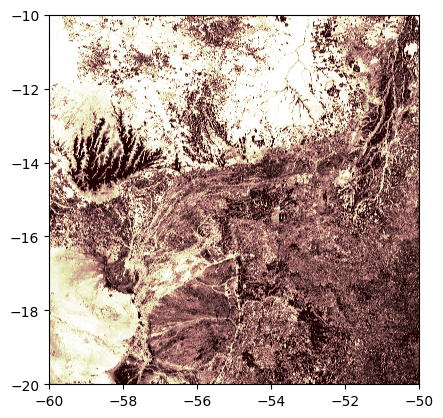

In [48]:
with rio.open("data/Hansen_GFC-2022-v1.10_treecover2000_10S_060W.tif") as src:

    print(f'Number of bands: {src.count}')
    print(f'Image resolution: ({src.height}, {src.width})')
    print(f'Coordinate Reference System: ({src.crs}')

    fig, ax = plt.subplots()

    extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
    ax = show(src, extent=extent, ax=ax, cmap="pink")

In [ ]:
df[df.treecover2000 > 0]

In [ ]:
df[df['2014'] != 0].head()

In [2]:
# spanning the range 180W-180E and 80N-60S
# 80N, 70N, ... 10N, 00N, 10S, 20S, ... 50S - 180W
# 80N - 180W, 170W, ... 010W, 000E, 010E.... 170E

# https://worldpopulationreview.com/country-rankings/deforestation-rates-by-country
# https://gist.github.com/graydon/11198540
# 'BR': ('Brazil', (-73.9872354804, -33.7683777809, -34.7299934555, 5.24448639569)),
# 'ID': ('Indonesia', (95.2930261576, -10.3599874813, 141.03385176, 5.47982086834)),
# 'CD': ('Congo (Kinshasa)', (12.1823368669, -13.2572266578, 31.1741492042, 5.25608775474)),
# 'CG': ('Congo (Brazzaville)', (11.0937728207, -5.03798674888, 18.4530652198, 3.72819651938)),
# 'AO': ('Angola', (11.6400960629, -17.9306364885, 24.0799052263, -4.43802336998)),
# Tazmania
# 'MM': ('Myanmar', (92.3032344909, 9.93295990645, 101.180005324, 28.335945136)),
# 'PY': ('Paraguay', (-62.6850571357, -27.5484990374, -54.2929595608, -19.3427466773)),
# 'BO': ('Bolivia', (-69.5904237535, -22.8729187965, -57.4983711412, -9.76198780685)),
# 'MZ': ('Mozambique', (30.1794812355, -26.7421916643, 40.7754752948, -10.3170960425)),
# 'AR': ('Argentina', (-73.4154357571, -55.25, -53.628348965, -21.8323104794)),

# According to how many assets we have...

# long lat bottom left, long lat top right

# 'BR': ('Brazil', (-73.9872354804, -33.7683777809, -34.7299934555, 5.24448639569)),
earthenginepartners_hansen('data/assets_for_deforestation.csv', '\t', 
                           range(-33, 6, 10), range(-73, -35, 10), 
                           'data/assets_with_deforestation.csv', verbose=False)

# 'CN': ('China', (73.6753792663, 18.197700914, 135.026311477, 53.4588044297)),
earthenginepartners_hansen('data/assets_with_deforestation.csv', '\t', 
                           range(18, 54, 10), range(73, 136, 10), 
                           'data/assets_with_deforestation.csv', verbose=False)

# 'US': ('United States', (-171.791110603, 18.91619, -66.96466, 71.3577635769)),
earthenginepartners_hansen('data/assets_with_deforestation.csv', '\t', 
                           range(18, 72, 10), range(-171, -67, 10), 
                           'data/assets_with_deforestation.csv', verbose=False)



Cache missing files: 0it [00:00, ?it/s]

Cache missing files: 0it [00:00, ?it/s]
Cache missing files: 0it [00:00, ?it/s]
to_assets_with_lossyear for latitudes: range(-33, 6, 10) and longitudes: range(-73, -35, 10): 100%|██████████| 16/16 [00:30<00:00,  1.92s/it]
to_assets_with_treecover2000 for latitudes: range(-33, 6, 10) and longitudes: range(-73, -35, 10): 100%|██████████| 16/16 [00:18<00:00,  1.19s/it]
Cache missing files: 0it [00:00, ?it/s]
Cache missing files: 0it [00:00, ?it/s]
to_assets_with_lossyear for latitudes: range(18, 54, 10) and longitudes: range(73, 136, 10): 100%|██████████| 28/28 [01:26<00:00,  3.10s/it]
to_assets_with_treecover2000 for latitudes: range(18, 54, 10) and longitudes: range(73, 136, 10): 100%|██████████| 28/28 [00:45<00:00,  1.63s/it]
Cache missing files: 0it [00:00, ?it/s]
Cache missing files: 100%|██████████| 3/3 [00:38<00:00, 12.80s/it]
to_assets_with_lossyear for latitudes: range(18, 72, 10) and longitudes: range(-171, -67, 10): 100%|██████████| 66/66 [01:50<00:00,  1.67s/it]
to_assets_with

<Axes: >

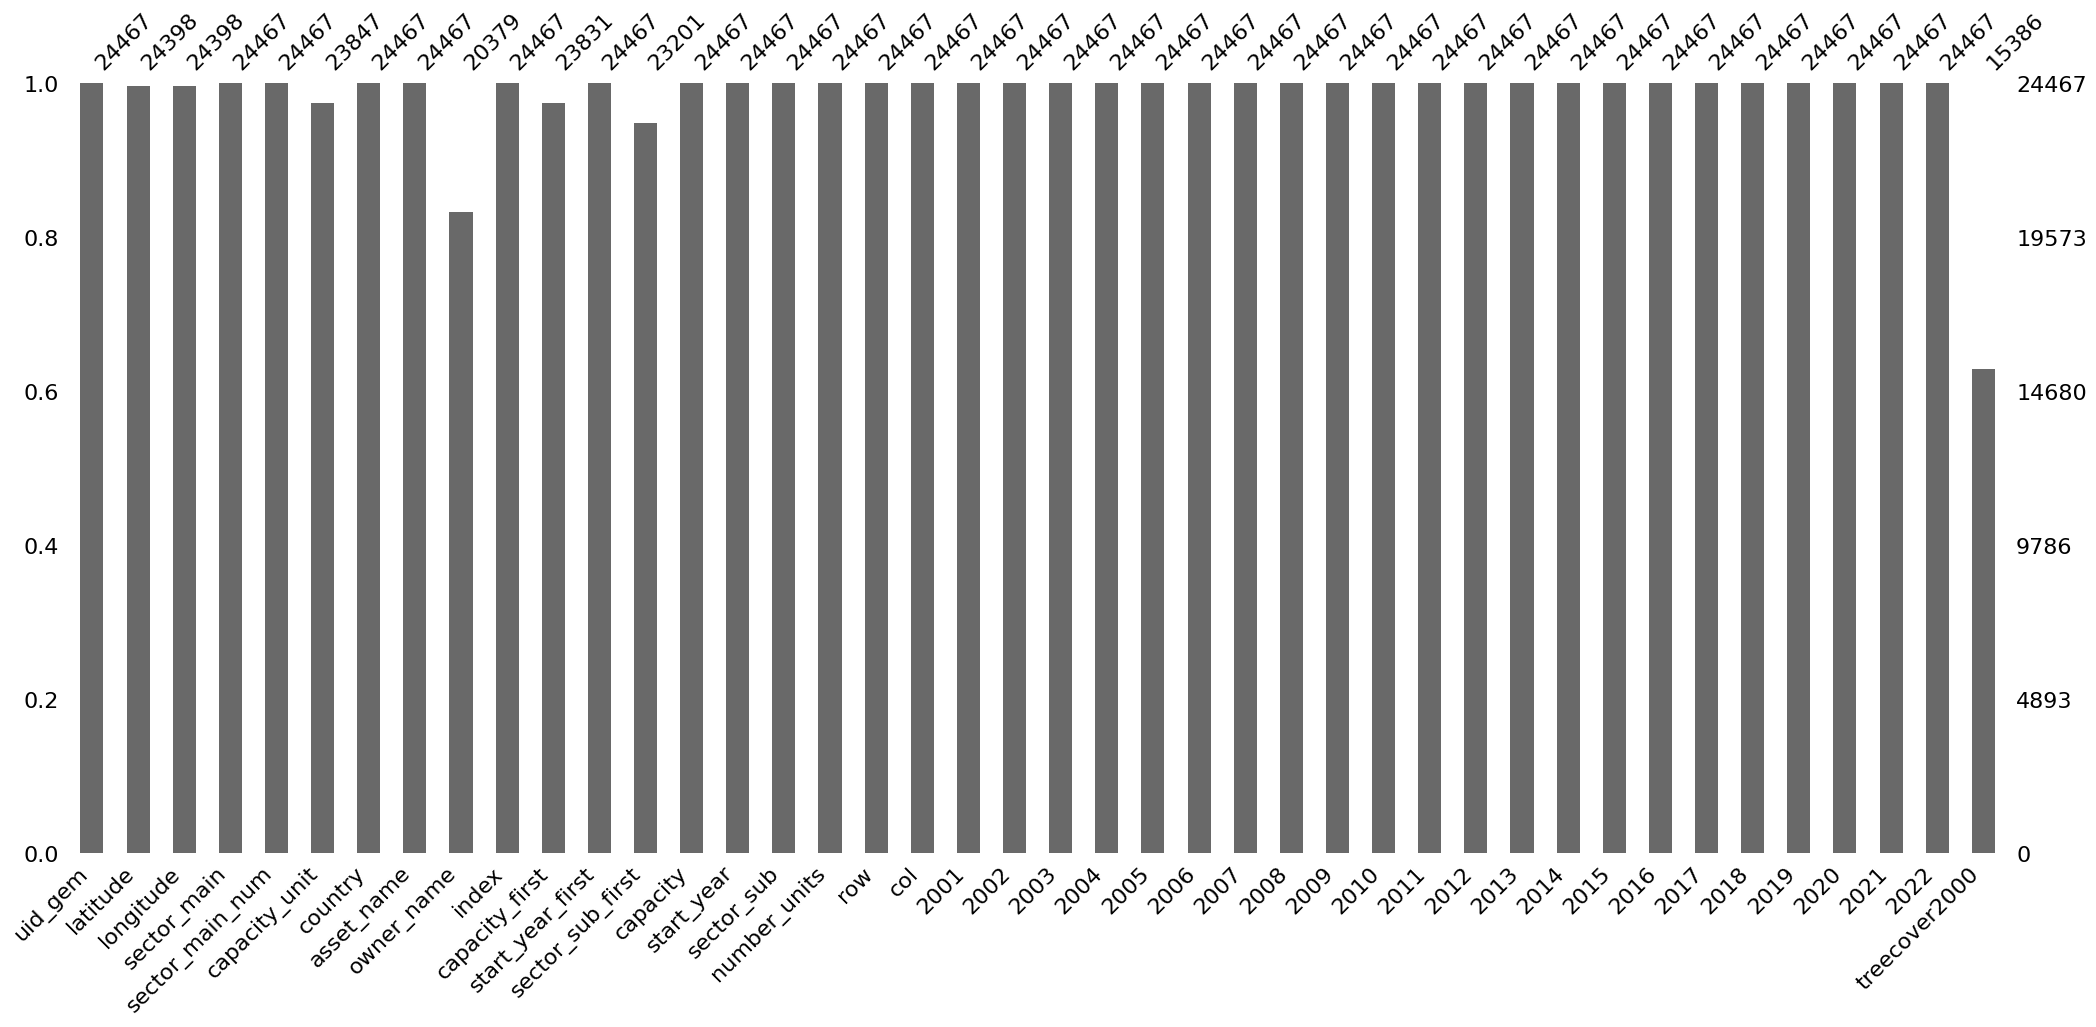

In [3]:
import missingno as msno

df = pd.read_csv('data/assets_with_deforestation.csv', sep='\t')
#df.country.value_counts().head(10)
df[df.treecover2000.notna()].head(10)
#df.isna().sum()
msno.bar(df)

In [10]:
for country in ['Brazil', 'China', 'United States']:
    value_counts = df[df.treecover2000.notna() & (df.country == country)].sector_main.value_counts()
    print(f'{country}\n{value_counts}\n')

Brazil
sector_main
bioenergy               155
wind power               77
hydropower               51
solar power              43
oil & gas extraction     22
steel                     6
coal plant                5
LNG terminal              2
nuclear                   1
coal mine                 1
Name: count, dtype: int64

China
sector_main
solar power             3767
wind power              3590
coal plant              1054
coal mine                761
bioenergy                409
hydropower               374
steel                    241
coal terminal             41
LNG terminal              28
oil & gas extraction      26
nuclear                   16
Name: count, dtype: int64

United States
sector_main
wind power       857
solar power      689
coal plant        39
coal mine         38
bioenergy         27
steel             22
geothermal         8
LNG terminal       8
hydropower         4
coal terminal      4
nuclear            2
Name: count, dtype: int64



<Axes: >

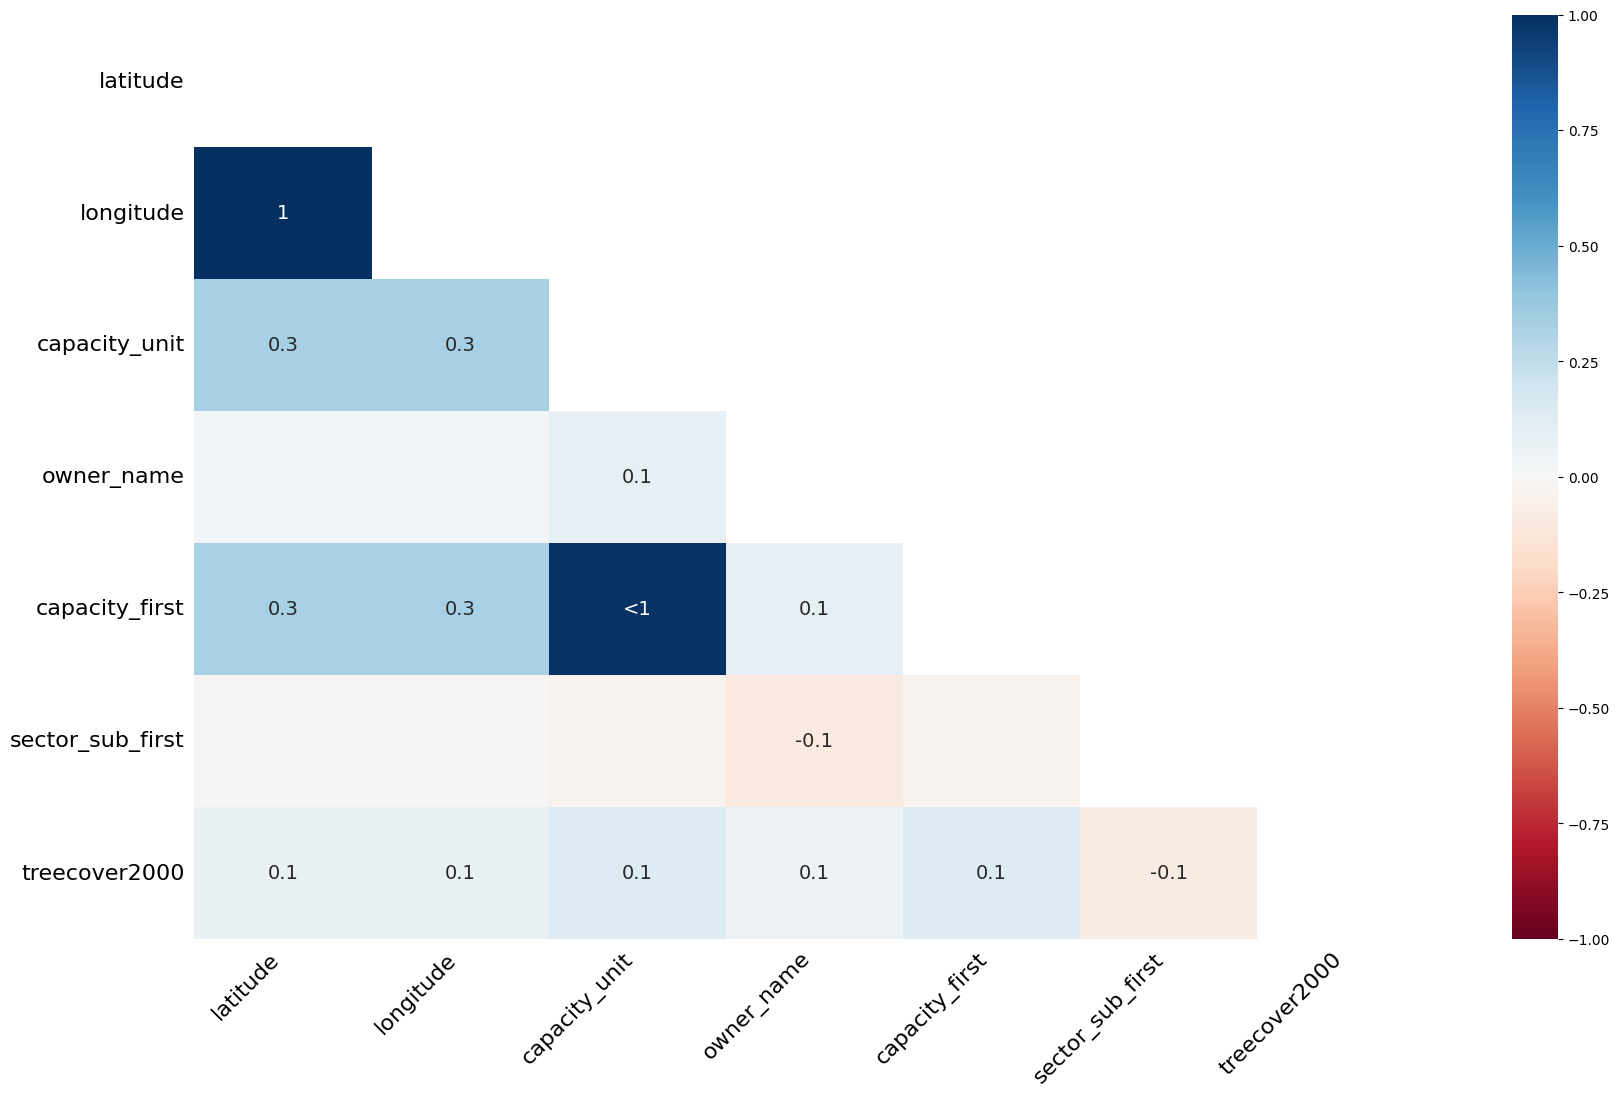

In [11]:
msno.heatmap(df)

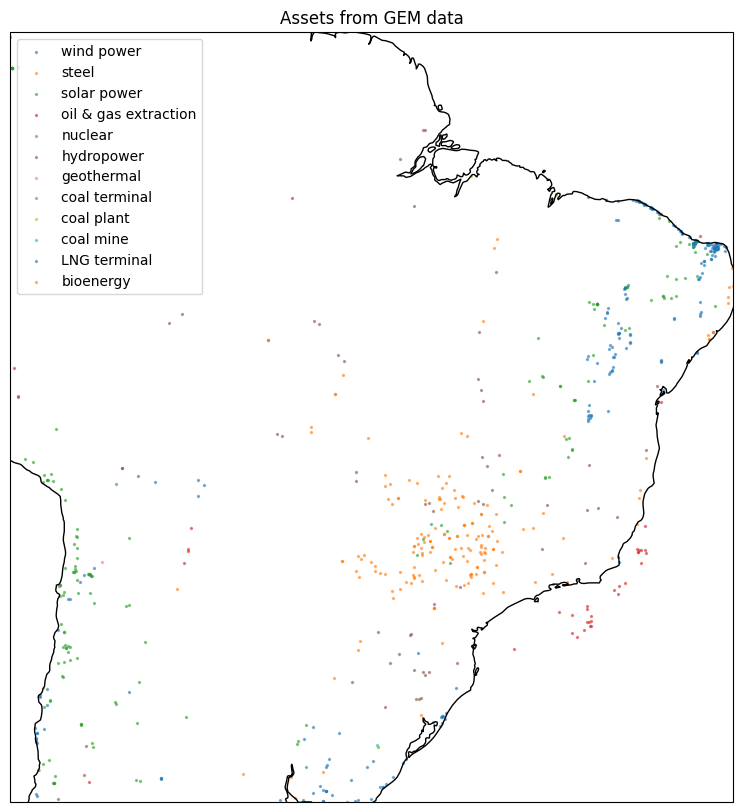

In [17]:
# Create a map of Brazil
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# 'BR': ('Brazil', (-73.9872354804, -33.7683777809, -34.7299934555, 5.24448639569)),
# range(-33, 6, 10), range(-73, -35, -10),
ax.set_extent([-73, -35, -33, 6])  # Define the extent of the map (lon_min, lon_max, lat_min, lat_max)

# Plot assets

for sector_main in df.sector_main.unique():
    foo = df[df.sector_main == sector_main]
    ax.scatter(foo['longitude'], foo['latitude'],
        marker='o', 
        s=2, alpha = 0.5, label=sector_main,
        transform=ccrs.PlateCarree())

# Add map features
ax.coastlines()

# Add country borders
# ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1)



# Add title and labels
plt.title('Assets from GEM data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')


# need to map sector_main_num 
ax.legend()

# Show the plot
plt.show()

# save the plot
#fig.savefig('graphs/map_assets_all.png', bbox_inches='tight')

In [7]:
df = pd.read_csv('data/regression_sample.csv', sep='\t')
#df.country.value_counts().head(10)
#df[df.country == 'Brazil'].head()


,uid_gem,latitude,longitude,sector_main,sector_main_num,capacity_unit,country,asset_name,owner_name,index,...,treecover2000,defo_total,y1,y3,y5,y7,defo_y1,defo_y3,defo_y5,defo_y7
13,L100118,-3.582700,-38.875000,coal plant,3,mw,Brazil,Porto do Pecém power station,EDP Brasil SA,27861,...,NaN,0.0,1,3,5,7,0.0,0.0,0.0,0.0
14,L100120,-2.587312,-44.338353,coal plant,3,mw,Brazil,Itaqui power station,Eneva SA,27852,...,NaN,0.0,1,3,5,7,0.0,0.0,0.0,0.0
15,L100121,-2.528300,-44.304400,coal plant,3,mw,Brazil,São Luis Alumar power station,Consorcio Alumar,27865,...,NaN,0.0,1,3,5,7,0.0,0.0,0.0,0.0
16,L100122,-1.569926,-48.754535,coal plant,3,mw,Brazil,Barcarena Alunorte power station,Hydro Alunorte,27850,...,NaN,0.0,1,3,5,7,0.0,0.0,0.0,0.0
17,L100128,-31.549407,-53.682978,coal plant,3,mw,Brazil,Pampa Sul power station,Grafito,27860,...,NaN,0.0,1,3,5,7,0.0,0.0,0.0,0.0
